In [12]:
import dask.dataframe as dd
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


pd.set_option('display.max_columns', None)
# Mostrar mais linhas (padrão é 10)
pd.set_option('display.max_rows', 100)

# Mostrar largura completa da tela
pd.set_option('display.width', None)

# Evita corte de conteúdo dentro das colunas
pd.set_option('display.max_colwidth', None)

In [13]:
# Lista de colunas que você quer carregar
colunas_necessarias = ['telefone_anonimizado', 'data_hora_inicio_atendimento', 'ani_valido']

# Ler apenas essas colunas
df = pd.read_csv('C:/Users/Marcelo Almeida/Documents/TRABALHO DE CONCLUSÃO DE CURSO/projeto-tcc/data/raw/aneel_anonimizados.csv', sep=',', encoding='latin1', usecols=colunas_necessarias)
df

,data_hora_inicio_atendimento,ani_valido,telefone_anonimizado
0,2024-08-16 08:44:03,1,6.614434e+10
1,2024-08-16 08:45:03,1,6.914625e+10
2,2024-08-16 08:45:40,1,3.911258e+10
3,2024-08-16 08:46:15,1,3.911375e+10
4,2024-08-16 08:50:07,1,9.111689e+10
...,...,...,...
16844127,2024-12-03 16:31:56.174,0,6.980868e+09
16844128,2024-10-23 13:26:31.817,0,6.811497e+10
16844129,2024-11-22 14:44:01.729,0,4.614956e+10
16844130,2024-10-10 22:20:10.705,0,4.911704e+10


In [14]:
# Converter para string corretamente, removendo .0 e mantendo número limpo
df['telefone_anonimizado_novo'] = df['telefone_anonimizado'].astype('Int64').astype(str)
def telefone_simples_valido(numero):
    if pd.isna(numero):
        return 0

    numero = str(numero).strip()

    if len(numero) < 8:
        return 0

    if numero == numero[0] * len(numero):
        return 0

    return 1
df['telefone_valido'] = df['telefone_anonimizado_novo'].apply(telefone_simples_valido)
df

,data_hora_inicio_atendimento,ani_valido,telefone_anonimizado,telefone_anonimizado_novo,telefone_valido
0,2024-08-16 08:44:03,1,6.614434e+10,66144343220,1
1,2024-08-16 08:45:03,1,6.914625e+10,69146250698,1
2,2024-08-16 08:45:40,1,3.911258e+10,39112584057,1
3,2024-08-16 08:46:15,1,3.911375e+10,39113749988,1
4,2024-08-16 08:50:07,1,9.111689e+10,91116889405,1
...,...,...,...,...,...
16844127,2024-12-03 16:31:56.174,0,6.980868e+09,6980868266,1
16844128,2024-10-23 13:26:31.817,0,6.811497e+10,68114968376,1
16844129,2024-11-22 14:44:01.729,0,4.614956e+10,46149560345,1
16844130,2024-10-10 22:20:10.705,0,4.911704e+10,49117043531,1


In [15]:
# Filtrar o DataFrame para incluir apenas linhas onde 'ani_valido' é 1 e 'data_hora_inicio_atendimento' não é nulo
df_mes = df.copy()
df_mes['data_hora_inicio_atendimento'] = df_mes['data_hora_inicio_atendimento'].astype(str).str.split('.').str[0]
df_mes['data_hora_inicio_atendimento'] = pd.to_datetime(df_mes['data_hora_inicio_atendimento'], errors='coerce')
df_mes['telefone_valido'] = df_mes['telefone_valido'].astype(int)

df_mes['linha_valida'] = np.where(
    ((df_mes['telefone_valido'] == 1) & (df_mes['data_hora_inicio_atendimento'].notnull())),
    1,
    0
)
df_mes = df_mes[df_mes['linha_valida'] == 1]

In [5]:
# Contar valores nulos por coluna
print(df_mes.isnull().sum().sort_values(ascending=False))

data_hora_inicio_atendimento    0
ani_valido                      0
telefone_anonimizado            0
telefone_anonimizado_novo       0
telefone_valido                 0
linha_valida                    0
dtype: int64


In [16]:
# Ordenar por cliente e data_hora_inicio_atendimento
df_mes = df_mes.sort_values(['telefone_anonimizado_novo', 'data_hora_inicio_atendimento'])

df_mes['tempo_ate_proxima'] = (
    df_mes.groupby('telefone_anonimizado_novo')['data_hora_inicio_atendimento']
    .shift(-1) - df_mes['data_hora_inicio_atendimento']
)
# Ver resultado
df_mes.head(100)    

,data_hora_inicio_atendimento,ani_valido,telefone_anonimizado,telefone_anonimizado_novo,telefone_valido,linha_valida,tempo_ate_proxima
14435013,2025-04-07 17:56:31,0,1.111107e+10,11111071988,1,1,0 days 00:06:54
14401508,2025-04-07 18:03:25,0,1.111107e+10,11111071988,1,1,NaT
10163686,2025-02-19 07:43:34,0,1.111108e+10,11111078104,1,1,0 days 01:16:59
10794347,2025-02-19 09:00:33,0,1.111108e+10,11111078104,1,1,NaT
1533439,2024-07-10 11:07:26,1,1.111109e+10,11111088577,1,1,NaT
10502560,2024-12-09 13:37:00,0,1.111109e+10,11111094291,1,1,0 days 00:20:03
14249444,2024-12-09 13:57:03,0,1.111109e+10,11111094291,1,1,NaT
10846989,2025-02-26 08:31:33,0,1.111110e+10,11111099233,1,1,NaT
7756436,2024-01-05 08:06:36,1,1.111127e+10,11111273858,1,1,143 days 11:02:16
2560292,2024-05-27 19:08:52,1,1.111127e+10,11111273858,1,1,176 days 01:00:06


In [17]:
df_mes['rechamada'] = df_mes['tempo_ate_proxima'].apply(lambda x: 0 if pd.isna(x) or x == '' else 1)
df_mes['rechamou_30dias'] = df_mes['tempo_ate_proxima'].apply(lambda x: 1 if x.total_seconds() < 2592000 else 0)
df_mes['rechamou_1h'] = df_mes['tempo_ate_proxima'].apply(lambda x: 1 if x.total_seconds() < 3600 else 0)
df_mes['rechamou_30min'] = df_mes['tempo_ate_proxima'].apply(lambda x: 1 if x.total_seconds() < 1800 else 0)
df_mes['rechamou_24h'] = df_mes['tempo_ate_proxima'].apply(lambda x: 1 if x.total_seconds() < 86400 else 0)
df_mes.head(10)

,data_hora_inicio_atendimento,ani_valido,telefone_anonimizado,telefone_anonimizado_novo,telefone_valido,linha_valida,tempo_ate_proxima,rechamada,rechamou_30dias,rechamou_1h,rechamou_30min,rechamou_24h
14435013,2025-04-07 17:56:31,0,1.111107e+10,11111071988,1,1,0 days 00:06:54,1,1,1,1,1
14401508,2025-04-07 18:03:25,0,1.111107e+10,11111071988,1,1,NaT,0,0,0,0,0
10163686,2025-02-19 07:43:34,0,1.111108e+10,11111078104,1,1,0 days 01:16:59,1,1,0,0,1
10794347,2025-02-19 09:00:33,0,1.111108e+10,11111078104,1,1,NaT,0,0,0,0,0
1533439,2024-07-10 11:07:26,1,1.111109e+10,11111088577,1,1,NaT,0,0,0,0,0
10502560,2024-12-09 13:37:00,0,1.111109e+10,11111094291,1,1,0 days 00:20:03,1,1,1,1,1
14249444,2024-12-09 13:57:03,0,1.111109e+10,11111094291,1,1,NaT,0,0,0,0,0
10846989,2025-02-26 08:31:33,0,1.111110e+10,11111099233,1,1,NaT,0,0,0,0,0
7756436,2024-01-05 08:06:36,1,1.111127e+10,11111273858,1,1,143 days 11:02:16,1,0,0,0,0
2560292,2024-05-27 19:08:52,1,1.111127e+10,11111273858,1,1,176 days 01:00:06,1,0,0,0,0


In [18]:
#verificar a proporção de rechamadas em 24h
cond = (df_mes['rechamou_24h'] == 1)
df_mes.loc[cond,'rechamou_30min'].value_counts(normalize=True)

rechamou_30min
0    0.512164
1    0.487836
Name: proportion, dtype: float64

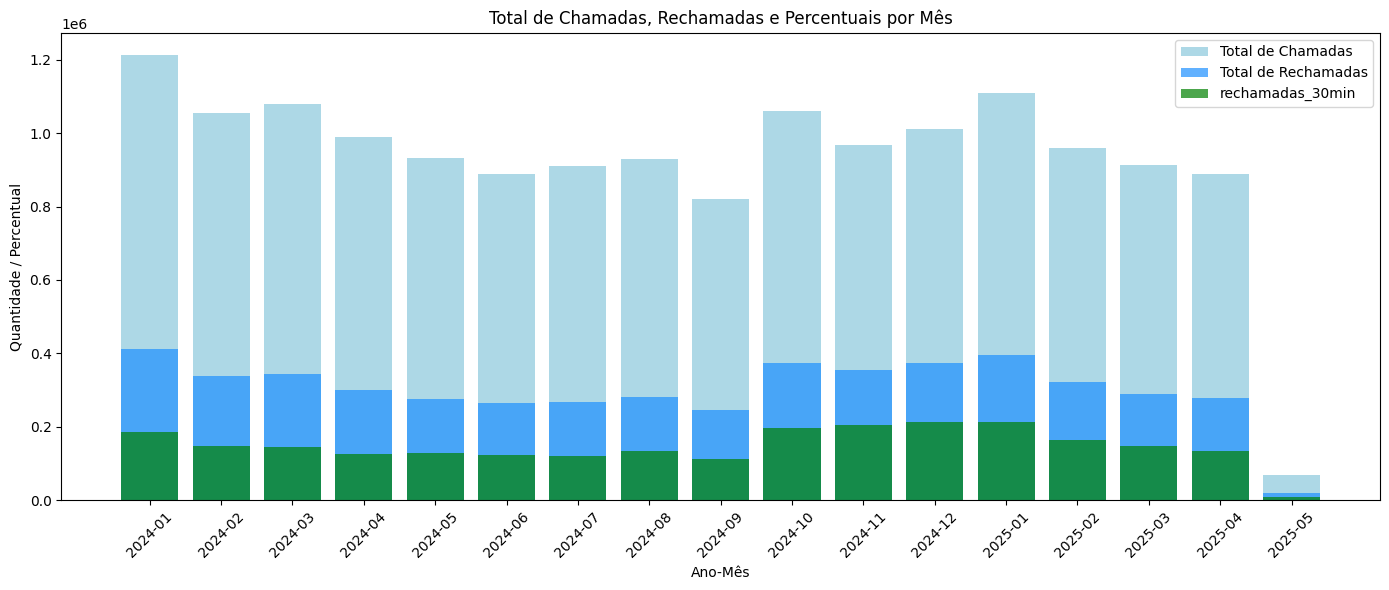

,ano_mes,total_chamadas,rechamadas_24h,rechamadas_30min,percentual_rechamada24h,percentual_rechamada_30min
0,2024-01,1212787,412608,184404,34.021473,15.204978
1,2024-02,1055259,339066,146950,32.131069,13.925491
2,2024-03,1079674,342468,143785,31.719575,13.317446
3,2024-04,989266,299197,126153,30.244343,12.752182
4,2024-05,932711,276286,128188,29.621823,13.743593
5,2024-06,887604,263619,121631,29.700069,13.703296
6,2024-07,910958,266487,120938,29.253489,13.275914
7,2024-08,928477,281360,132865,30.303389,14.309994
8,2024-09,819894,245374,112654,29.927527,13.740069
9,2024-10,1059731,373730,196723,35.266497,18.563485


In [19]:
# Cria a coluna 'ano_mes' no formato 'YYYY-MM'
df_mes['ano_mes'] = df_mes['data_hora_inicio_atendimento'].dt.to_period('M').astype(str)

df_mes_grouped_teste = df_mes.groupby('ano_mes').agg(
    total_chamadas=('rechamada', 'count'),           # total de registros no mês
    rechamadas_24h=('rechamou_24h', 'sum'),                  # total de rechamadas (onde rechamada == 1)
    rechamadas_30min=('rechamou_30min', 'sum')   # total de rechamadas em até 30min
).reset_index()
# Cálculo do percentual
df_mes_grouped_teste['percentual_rechamada24h'] = (df_mes_grouped_teste['rechamadas_24h'] / df_mes_grouped_teste['total_chamadas']) * 100
df_mes_grouped_teste['percentual_rechamada_30min'] = (df_mes_grouped_teste['rechamadas_30min'] / df_mes_grouped_teste['total_chamadas']) * 100
# plotando os dados
import matplotlib.pyplot as plt 
# Configurações do gráfico
plt.figure(figsize=(14, 6))
plt.bar(df_mes_grouped_teste['ano_mes'], df_mes_grouped_teste['total_chamadas'], label='Total de Chamadas', color='lightblue')
plt.bar(df_mes_grouped_teste['ano_mes'], df_mes_grouped_teste['rechamadas_24h'], label='Total de Rechamadas', color='dodgerblue', alpha=0.7)
plt.bar(df_mes_grouped_teste['ano_mes'], df_mes_grouped_teste['rechamadas_30min'], label='rechamadas_30min', color='green', alpha=0.7)
plt.xlabel('Ano-Mês')
plt.ylabel('Quantidade / Percentual')
plt.title('Total de Chamadas, Rechamadas e Percentuais por Mês')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()
df_mes_grouped_teste

C:\Users\Marcelo Almeida\AppData\Local\Temp\ipykernel_13192\1030441941.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mes_teste['tempo_ate_proxima'] = df_mes_teste['tempo_ate_proxima'].dt.total_seconds() / 60


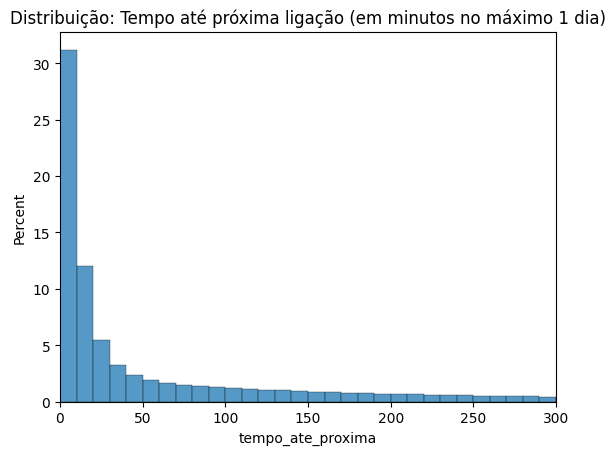

In [21]:
# Histograma de tempo até a próxima ligação (em minutos)
#df_mes['tempo_ate_proxima'] = df_mes['tempo_ate_proxima'].dt.total_seconds() / 86400
df_mes_teste = df_mes[df_mes['tempo_ate_proxima'].notna()]
df_mes_teste = df_mes[df_mes['tempo_ate_proxima'] <= pd.Timedelta(days=1)]
bins = np.arange(0, 1441, 10)
df_mes_teste['tempo_ate_proxima'] = df_mes_teste['tempo_ate_proxima'].dt.total_seconds() / 60
sns.histplot(df_mes_teste['tempo_ate_proxima'].dropna(), bins=bins, stat="percent")
plt.title("Distribuição: Tempo até próxima ligação (em minutos no máximo 1 dia)")
plt.xlim(0, 300) 
plt.show()

C:\Users\Marcelo Almeida\AppData\Local\Temp\ipykernel_13192\3418921627.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mes_teste['tempo_ate_proxima'] = df_mes_teste['tempo_ate_proxima'].dt.total_seconds() / 60


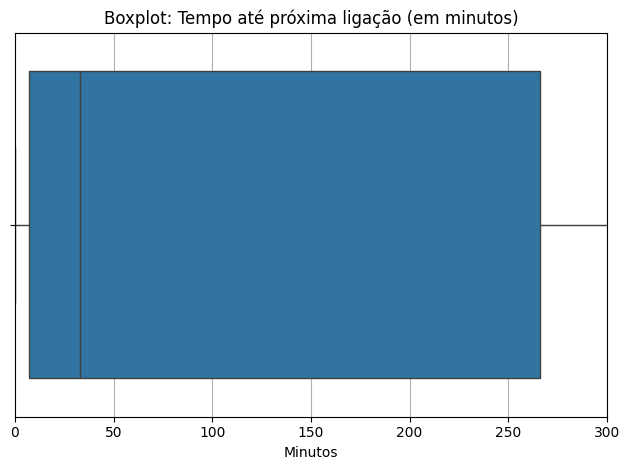

In [22]:
# Histograma de tempo até a próxima ligação (em minutos)
#df_mes['tempo_ate_proxima'] = df_mes['tempo_ate_proxima'].dt.total_seconds() / 86400
df_mes_teste = df_mes[df_mes['tempo_ate_proxima'].notna()]
df_mes_teste = df_mes[df_mes['tempo_ate_proxima'] <= pd.Timedelta(days=1)]
df_mes_teste['tempo_ate_proxima'] = df_mes_teste['tempo_ate_proxima'].dt.total_seconds() / 60

sns.boxplot(x=df_mes_teste['tempo_ate_proxima'])
plt.title("Boxplot: Tempo até próxima ligação (em minutos)")
plt.xlabel("Minutos")
plt.grid(True)
plt.xlim(0, 300)  # Limita o eixo para facilitar leitura
plt.tight_layout()
plt.show()